In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

### This project is used for class 2018-0507 MSDS 7335 Machine Learning at SMU

-  hosted on https://github.com/post2web/santander
- by Ivelin Angelov

# Vector Representation of sparse data

Santander Group's dataset is a good example of challenge where we have a very sparse high dimensional dataset and before we can do supervised machine learning we have to represent the dataset with a denser and less dimensional representation. The competition has two datasets: 
- train.csv with approx dimensions 4459x4992. The training data represents 4459 observations with 4991 features and 1 target variable.
- test.csv with approx dimensions 49342x4991. It has more than ten times the number of observations as compared to the training data. It doesn't have a target variable. This is what we are asked to predict by the competition.

All features names are sanitization with random strings. There is no information given of what they mean. From exploration, we came to the conclusion that they represent the amount of money for different categories that are used in the transaction with a customer. The targets (labels) in the training dataset represent the value of transactions for each potential customer.

## Data exploration

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print('Train Dataset shape', train.shape)
print('Test Dataset shape', train.shape)

Train Dataset shape (4459, 4993)
Test Dataset shape (4459, 4993)


### Head of Train Dataset

In [3]:
train.head(2)

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


### Head of Test Dataset

In [4]:
test.head(2)

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Distribution of the labesl

The labels have minimum of 30000 and maximum of 40000000


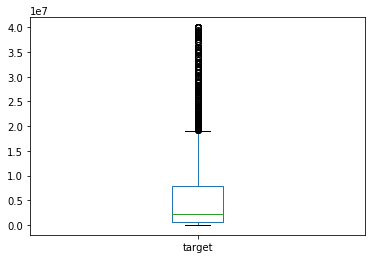

In [5]:
train['target'].plot(kind='box')
print('The labels have minimum of %d and maximum of %d' % (train['target'].min(), train['target'].max()))

## Features exploration

Most of the values in the two datasets are zeros and zeros most probably represent missing value for the amount in a certain category. 

In [6]:
features = train.iloc[:,2:].astype(np.int32)#.append(test)

### Percent missing values

In [7]:
percent_zeros = (features==0).sum(axis=1).mean() / features.shape[1] * 100
print(percent_zeros, 'percent of the features are zeros (missing values)')

96.85413111171313 percent of the features are zeros (missing values)


## Distribution

The distribution shows mostly zeros, two negative values, and some transaction amount values.

The labels have minimum of -2147483648 and maximum of 960000000


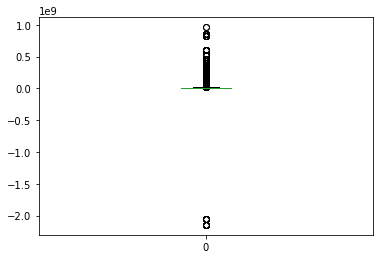

In [8]:
values_vector = features.values.flatten()
values_vector = values_vector[values_vector!=0]
pd.DataFrame(values_vector).plot(kind='box')
print('The labels have minimum of %d and maximum of %d' % (values_vector.min(), values_vector.max()))

### Distribution of the positive values

The labels have minimum of 52 and maximum of 960000000


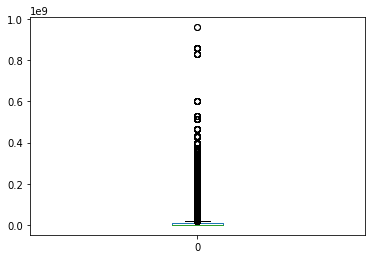

In [9]:
values_vector = features.values.flatten()
values_vector = values_vector[values_vector>0]
pd.DataFrame(values_vector).plot(kind='box')
print('The labels have minimum of %d and maximum of %d' % (values_vector.min(), values_vector.max()))

## Feature Selection

Top 1000 features are selected based on a ranking of a random forest model, where 1000 is a hyperparameter that could be optimized. This step could also be skipped or executed after the preprocessing step

![](images/3.png)

### Features preprocessing

To make the distribution less skewed, I first remove the negative values (only two values) and log all features.

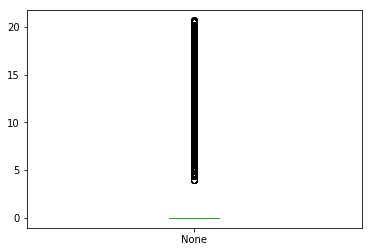

In [23]:
preprocessed_features = features.copy()
preprocessed_features[preprocessed_features.values<0] = 0.
preprocessed_features = np.log(preprocessed_features+1)
values_vector = preprocessed_features.values.flatten()
assert preprocessed_features.min().min() >= 0.
pd.Series(values_vector).plot(kind='box')

To center the data around zeros I first create a new feature representing flags for the missing values (zeros) and remove the median from the data.

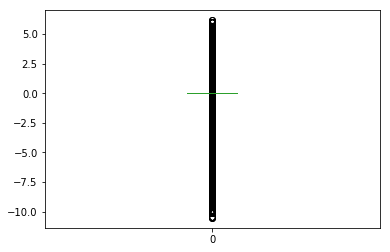

In [24]:
zero_flags = preprocessed_features == 0.
zero_flags.columns = [c+'_flag' for c in zero_flags.columns]
values_vector = preprocessed_features.values.flatten()
data_center = np.median(values_vector[values_vector>0])

preprocessed_features[~zero_flags] = preprocessed_features[~zero_flags] - data_center
values_vector = preprocessed_features.values.flatten()
pd.DataFrame(values_vector).plot(kind='box')

preprocessed_features = pd.concat([preprocessed_features, zero_flags], axis=1)

## Dimensionality reduction

The data is now approximately normally distributed but because for every feature I create a new "missing flag" it becomes even more sparse and wide. 

Two forms of dimensionality reduction are applied and compared - PCA and Autoencoder. LDA is not considered here, because the testing dataset is more than ten times larger than the training and it will be of great value if included in the dimensionality reduction process. 

### Measure of information loss

To get some form of unsupervised performance measurements, compare the MSE of the reconstruction of PCA and Autoencoder. The reconstruction MSE for the Autoencoder doesn't seem to be affected by the number of dimensions. It seems all values could fit in 2 dimensions with about the same efficiency as they would in 128 dimensions. This is a red flag for the Autoencoder and it could mean that even with a lot of hyperparameter searching, I didn't achieve good training.
![](images/1.png)

# Recreating the analysis

## Download raw data files

Login to Kaggle and download the data files from "Santander Value Prediction Challenge": [train.csv](https://www.kaggle.com/c/santander-value-prediction-challenge/download/train.csv), [test.csv](https://www.kaggle.com/c/santander-value-prediction-challenge/download/test.csv). Place the files in the data folder in the root of the project. 

## All steps of the ML pipeline are implemented in Jupyter notebooks. 

There are extra details and hyperparameters inside every notebook

### Preprocess

- This process is executed in a preprocessing notebook: preprocess.ipynb

It will apply the preprocessing logic and will save the result to `data/train_transformed.h5` and `data/test_transformed.h5`.

### Feature Importance

- This process is executed in a preprocessing notebook: feature_importance.ipynb

It will rank the features and save the ranking as to `data/importance.h5`.

### Dimentionality reduction

PCA and Autoencoder are applied to the training dataset. Both training and testing datasets are used for "trained" with the testing dataset. A validation subset is used to measure unsupervised performance and early stopping.

- PCA is implemented with sklean in `run_pca.ipynb`. After executing the notebook, folder `pca_result` will be populated with files representing encoded the training dataset for number different number of dimensions and validation reconstructions for unsupervised comparison.
- Autoencoder is implemented with tensorflow in `run_ed.ipynb`, `ed.py`, `export_ed.py`. After executing the notebook, folder `ed_model_dirs` will be populated with files representing encoded the training dataset for number different number of dimensions, validation reconstructions for unsupervised comparison and checkpoints for the tensorflow encoder-decoder models. The execution of the Autoencoder takes multiple hours with a fast GPU.

#### Dimentionality reduction unsupervied result
![](images/2.png)

### Supervised training

After the two different dimensionality reduction methods are executed, for every method and every number of dimensions we can apply three different supervised regression methods: Linear Regression, Random Forest, and Neural Network

- Linear Regression, Random Forest is implemented in a notebook: `ll_rf.ipynb` with sklern. 
- Neural Network is implemented with tensorflow in notebook `nn.ipynb`, `nn.py` and `nn_export.py`. The execution of the Neural Network takes multiple hours with a fast GPU.

#### Linear Regression result

![](images/lr.png)

#### Random Forest Regression result

![](images/rf.png)

#### Neural Network Regression result

![](images/nn.png)